Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

In [ ]:
# Libaries for model building
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Import Library for working locally, or in Colab
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Regression II

In this project, you'll continue working with the New York City rent dataset you used in the last module project.

## Directions

The tasks for this project are as follows:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two new features.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `Linearregression` model.
- **Task 7:** Calculate the training and test mean absolute error for your model.
- **Task 8:** Calculate the training and test $R^2$ score for your model.
- **Stretch Goal:** Determine the three most important features for your linear regression model.

**Note**

You should limit yourself to the following libraries for this project:

- `matplotlib`
- `numpy`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [ ]:
# Sourcing the filepath
filepath = DATA_PATH + 'apartments/renthop-nyc.csv'

# Writing a function to wrangle the data
def wrangle(filepath):
    df = pd.read_csv(filepath,parse_dates=['created'],index_col=['created'])

    # Remove the most extreme 1% prices,
    # the most extreme .1% latitudes, &
    # the most extreme .1% longitudes
    df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
            (df['price'] <= np.percentile(df['price'], 99.5)) & 
            (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
            (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
            (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
            (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
    
    # Removing the columns with highest level of caridnal value
    threshold = .75*len('created')
    cols_drop = []
    for cols in df.select_dtypes('object'):
      if df[cols].nunique() > threshold:
        cols_drop.append(cols)
    df.drop(columns=cols_drop,inplace=True)

    # Create numeric values to represent the level of interest
    df.loc[df['interest_level'] == 'low', 'interest_level'] = 1
    df.loc[df['interest_level'] == 'medium', 'interest_level'] = 2
    df.loc[df['interest_level'] == 'high', 'interest_level'] = 3

    # Cleaning the interest_level to be int
    df['interest_level'] = df['interest_level'].astype(int)

    # Feature engineering total number of rooms per house
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']

    # Assigning the variable that includes all the columns we'd like to sum
    features_summed = df[['elevator','hardwood_floors','doorman','dishwasher',
                          'no_fee','dogs_allowed','cats_allowed','laundry_in_building',
                          'fitness_center','pre-war','laundry_in_unit','roof_deck',
                          'outdoor_space','dining_room','high_speed_internet','balcony',
                          'swimming_pool','new_construction','terrace','exclusive','loft',
                          'garden_patio','wheelchair_access','common_outdoor_space']]
    
    # Features summed by row
    df['features_summed'] = features_summed.sum(axis=1)
    
    # Drop old features
    cols_to_drop = ['bedrooms','bathrooms','elevator','hardwood_floors','doorman',
                    'dishwasher','no_fee','dogs_allowed','cats_allowed','laundry_in_building',
                    'fitness_center','pre-war','laundry_in_unit','roof_deck','outdoor_space',
                    'dining_room','high_speed_internet','balcony','swimming_pool','new_construction',
                    'terrace','exclusive','loft','garden_patio','wheelchair_access','common_outdoor_space']
    df.drop(columns=cols_to_drop,inplace=True)

    # Re-ordering Columns
    df = df[['price','total_rooms','features_summed','interest_level','latitude','longitude']]

    return df

**Task 1:** Add the following functionality to the above `wrangle` function.

- The `'created'` column will parsed as a `DateTime` object and set as the `index` of the DataFrame. 
- Rows with `NaN` values will be dropped.

Then use your modified function to import the `renthop-nyc.csv` file into a DataFrame named `df`.

In [ ]:
# Reading in the data for initial previews before cleaning
df = pd.read_csv(DATA_PATH + 'apartments/renthop-nyc.csv')

In [ ]:
# Previewing data of the set
df.info()

In [ ]:
# Finding the perecentage of null values within the set
((df.isnull()).sum()*100/len(df)).round(2)

In [ ]:
# Df cleaned by using the wrangle function
df = wrangle(DATA_PATH + 'apartments/renthop-nyc.csv')

In [ ]:
# Df cleanned set preview
df

,price,total_rooms,features_summed,interest_level,latitude,longitude
created,,,,,,
2016-06-24 07:54:24,3000,4.5,0,2,40.7145,-73.9425
2016-06-12 12:19:27,5465,3.0,5,1,40.7947,-73.9667
2016-04-17 03:26:41,2850,2.0,3,3,40.7388,-74.0018
2016-04-18 02:22:02,3275,2.0,2,1,40.7539,-73.9677
2016-04-28 01:32:41,3350,5.0,1,1,40.8241,-73.9493
...,...,...,...,...,...,...
2016-06-02 05:41:05,3200,3.0,5,2,40.7426,-73.9790
2016-04-04 18:22:34,3950,2.0,9,1,40.7102,-74.0163
2016-04-16 02:13:40,2595,2.0,5,1,40.7601,-73.9900


In [ ]:
# df corralation to see which values are more correlated to the target variable
df.corr()

,price,total_rooms,features_summed,interest_level,latitude,longitude
price,1.000000,0.649097,0.305263,-0.203596,-0.036286,-0.251004
total_rooms,0.649097,1.000000,0.170926,0.007831,0.007209,0.036503
features_summed,0.305263,0.170926,1.000000,0.040837,-0.068345,-0.256118
interest_level,-0.203596,0.007831,0.040837,1.000000,-0.046203,0.059222
latitude,-0.036286,0.007209,-0.068345,-0.046203,1.000000,0.329185
longitude,-0.251004,0.036503,-0.256118,0.059222,0.329185,1.000000


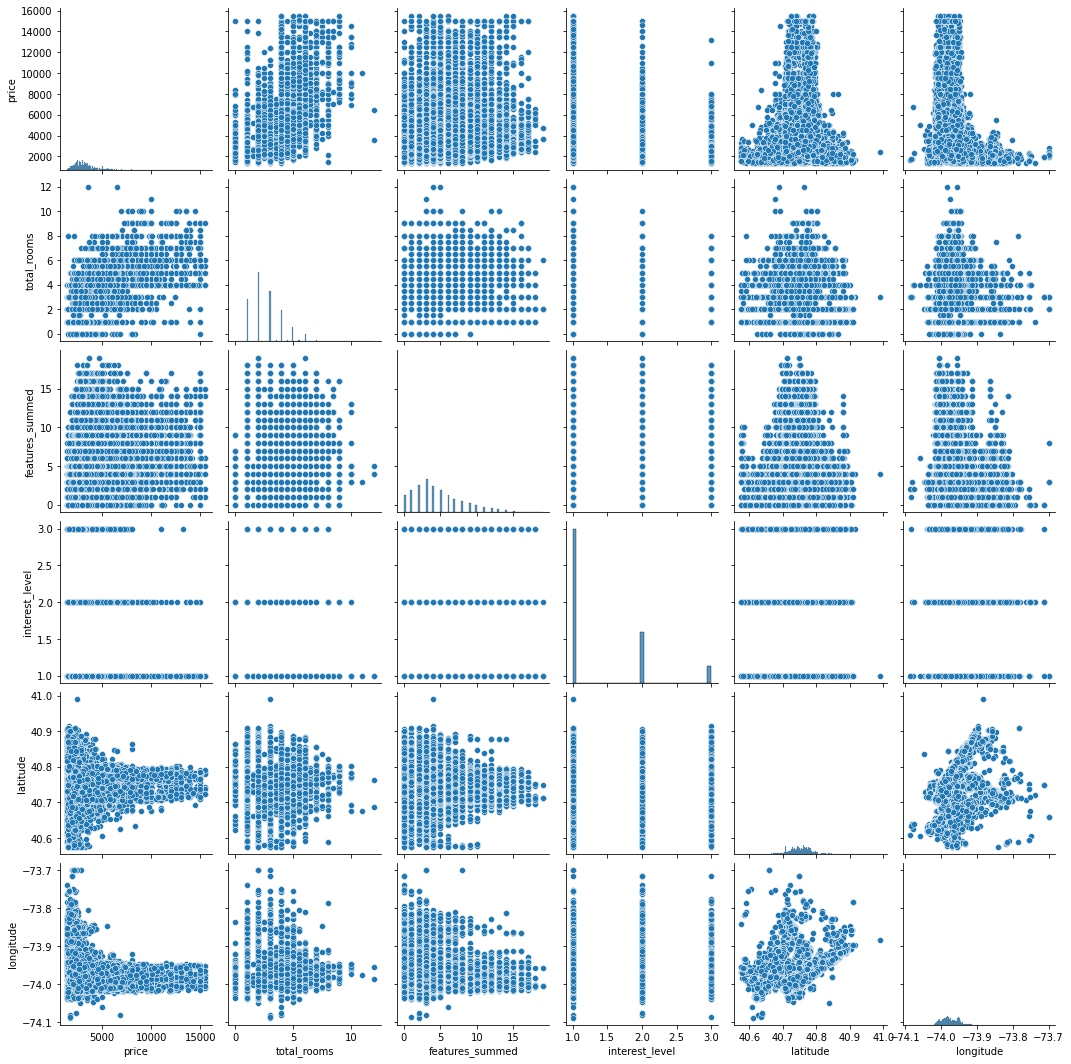

In [ ]:
# Pairplot to preview the distribution of data
sns.pairplot(df);

**Task 2:** Using your `pandas` and dataviz skills decide on two features that you want to engineer for your dataset. Next, modify your `wrangle` function to add those features. 

**Note:** You can learn more about feature engineering [here](https://en.wikipedia.org/wiki/Feature_engineering). Here are some ideas for new features:

- Does the apartment have a description?
- Length of description.
- Total number of perks that apartment has.
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths).

In [ ]:
# Conduct your exploratory data analysis here, 
# and then modify the function above.

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'price'`.

**Note:** In contrast to the last module project, this time you should include _all_ the numerical features in your dataset.

In [ ]:
# Define the Features, and Target variables
target = 'price'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from April and May 2016. 
- Your test set should include data from June 2016.

In [ ]:
# Define the cutoff month's numeric value
cutoff = 6

# Create a mask to seperate dates using the cutoff
mask = X.index.month < cutoff

# Create your train, and tests sets using the mask created above
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [ ]:
# Testing the shape of the data to see if code above worked
X_train.shape, X_test.shape

((31844, 5), (16973, 5))

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model. First, calculate the mean of `y_train`. Next, create a list `y_pred` that has the same length as `y_train` and where every item in the list is the mean. Finally, use `mean_absolute_error` to calculate your baseline.

In [ ]:
# Assign the value of the training mean * the length of the training set to the y prediction variable
y_pred = [y_train.mean()]*len(y_train)

# Assign the baseline mean of absolute error to the MAE(ytrain,ypredict)
baseline_mae = mean_absolute_error(y_train,y_pred)

# Print the training Mean, and the Baseline MAE
print('Rent Price:', y_train.mean())
print('--------------------------------------------')
print('Baseline MAE:', baseline_mae)

Rent Price: 3575.604007034292
--------------------------------------------
Baseline MAE: 1201.8811133682555


# IV. Build Model

**Task 6:** Build and train a `LinearRegression` model named `model` using your feature matrix `X_train` and your target vector `y_train`.

In [ ]:
# Instantiate the predictor
model = LinearRegression()

# Fit predictor on the (training) data
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# V. Check Metrics

**Task 7:** Calculate the training and test mean absolute error for your model.

In [ ]:
# Assign the y_pred linear regression train/test variables from the model.predict of the X train/test
y_pred_train_lr = model.predict(X_train)
y_pred_test_lr = model.predict(X_test)

# Assign the training MAE, and Test MAE from the MAE function using the ytrain/pred LR, and ytest/pred LR
training_mae = mean_absolute_error(y_train, y_pred_train_lr)
test_mae = mean_absolute_error(y_test, y_pred_test_lr)

# Printing the training, and test MAE
print('Training MAE:', training_mae)
print('--------------------------------------------')
print('Test MAE:', test_mae)

Training MAE: 753.9493166722643
--------------------------------------------
Test MAE: 759.4155203034362


**Task 8:** Calculate the training and test $R^2$ score for your model.

In [ ]:
# Assign the training R^2 value to the training / test variables using the X/y train and test values
training_r2 = model.score(X_train,y_train)
test_r2 = model.score(X_test,y_test)

# Print the R2'd training/test score
print('Training R^2 Score:', training_r2)
print('--------------------------------------------')
print('Test R^2 Score:', test_r2)

Training R^2 Score: 0.5525352919452493
--------------------------------------------
Test R^2 Score: 0.5594456500208675


# VI. Communicate Results

**Stretch Goal:** What are the three most influential coefficients in your linear model? You should consider the _absolute value_ of each coefficient, so that it doesn't matter if it's positive or negative.

In [ ]:
# Previewing the data to make anaylsis on column positioning
df

,price,total_rooms,features_summed,interest_level,latitude,longitude
created,,,,,,
2016-06-24 07:54:24,3000,4.5,0,2,40.7145,-73.9425
2016-06-12 12:19:27,5465,3.0,5,1,40.7947,-73.9667
2016-04-17 03:26:41,2850,2.0,3,3,40.7388,-74.0018
2016-04-18 02:22:02,3275,2.0,2,1,40.7539,-73.9677
2016-04-28 01:32:41,3350,5.0,1,1,40.8241,-73.9493
...,...,...,...,...,...,...
2016-06-02 05:41:05,3200,3.0,5,2,40.7426,-73.9790
2016-04-04 18:22:34,3950,2.0,9,1,40.7102,-74.0163
2016-04-16 02:13:40,2595,2.0,5,1,40.7601,-73.9900


In [ ]:
# Finding the coefficient's values presented in an array
model.coef_

array([   790.84797008,     74.37187399,   -554.35846721,   1673.02305441,
       -14494.54243732])

# The Three Most Influential Coefficents -
1. Longitude
2. Latitude
3. Total Rooms